In [ ]:
# This is a model selction notebook for predicting delivery times using nueral network training w TensorFlow

In [85]:
"""
some code attribution 
1. Raschka, S. (2015). Python Machine Learning. Birmingham, England: Packt Publishing.
2. Lopez de Prado, M. (2018). Advances in financial machine learning. Nashville, TN: John Wiley & Sons.
3. Hull, J.C. (2019). Machine Learning in Business.  

"""

'\nsome code attribution \n1. Raschka, S. (2015). Python Machine Learning. Birmingham, England: Packt Publishing.\n2. Lopez de Prado, M. (2018). Advances in financial machine learning. Nashville, TN: John Wiley & Sons.\n3. Hull, J.C. (2019). Machine Learning in Business.  \n\n'

In [1]:
# imports
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from sklearn.preprocessing import RobustScaler

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow import keras

In [19]:
# load data
DATA_FOLDER = 'C:/Users/bscot/OneDrive/Documents/DoorDash/DoorDash2'
data = pd.read_csv(os.path.join(DATA_FOLDER, 'historical_imputed.csv'))
X_load = data.drop('total delivery duration seconds', axis=1)
transformer = RobustScaler().fit(X_load)
X_scaled = transformer.transform(X_load)
X = pd.DataFrame(X_scaled, columns = X_load.columns)
y = data[['total delivery duration seconds']]

# divide data into training set and test set for holdout method
X_train_scaled,X_test_scaled,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=100)

print('X_scaled_train dataframe is: ',X_train_scaled.shape)
print('y_train dataframe is: ',y_train.shape)
print('X_scaled_test dataframe is: ',X_test_scaled.shape)
print('y_test dataframe is: ',y_test.shape)

X_scaled_train dataframe is:  (157942, 90)
y_train dataframe is:  (157942, 1)
X_scaled_test dataframe is:  (39486, 90)
y_test dataframe is:  (39486, 1)


In [20]:
# check contents
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_load.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_load.columns)
y_train = pd.DataFrame(y_train, columns = y.columns)
y_test = pd.DataFrame(y_test, columns = y.columns)
#print(X_scaled_train.head(10))
#print(X_scaled_test.head(10))
#print(y_train.head(10))
#print(y_test.head(10))

In [21]:
# define model
perceptron_model = keras.models.Sequential([Dense(20,activation = "sigmoid",input_shape = (90,)),
                                             Dense(20,activation = "sigmoid"),Dense(20,activation = "sigmoid"),
                                                Dense(1)])

perceptron_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 20)                1820      
_________________________________________________________________
dense_29 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_30 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 21        
Total params: 2,681
Trainable params: 2,681
Non-trainable params: 0
_________________________________________________________________


In [22]:
# compile model
perceptron_model.compile(optimizer='adam', loss='mae')

In [23]:
# save checkpoints
checkpoint = keras.callbacks.ModelCheckpoint("best_model", save_best_only = True)
# early stopping trigger
kickout = keras.callbacks.EarlyStopping(patience = 100, restore_best_weights = True)

In [25]:
t0 = time()
# train model 
num_epochs = 3000
training_size = 100
batch_size = 2
steps_per_epoch = np.ceil(training_size/batch_size)
# data set length must be >= (training/batch)*epochs
#
history=perceptron_model.fit(X_train_scaled,y_train,
                             epochs=num_epochs,
                             steps_per_epoch=steps_per_epoch,
                             #callbacks=[checkpoint,kickout],
                             verbose=0)
t0_nn = (time() - t0)
print("done in %0.3fs" % (t0_nn))

done in 485.840s


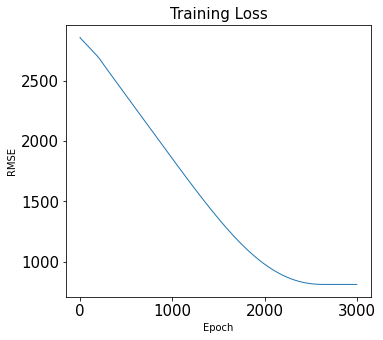

In [26]:
# visualize learning curve
hist = history.history
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
ax.plot(hist['loss'],lw=1)
ax.set_title('Training Loss',size=15)
ax.set_xlabel('Epoch',size=10)
ax.set_ylabel('RMSE',size=10)
ax.tick_params(axis='both',which='major',labelsize=15)
#
plt.show()

In [27]:
# eval trained model on test set
mae_nn_test = perceptron_model.evaluate(X_test_scaled,y_test,verbose=0)
print('Neural network RMSE on test set:', mae_nn_test)

Neural network RMSE on test set: 801.0652465820312


In [107]:
# Use Lasso for feature reduction
# Use PCA for feature reduction 

C:\Users\bscot\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


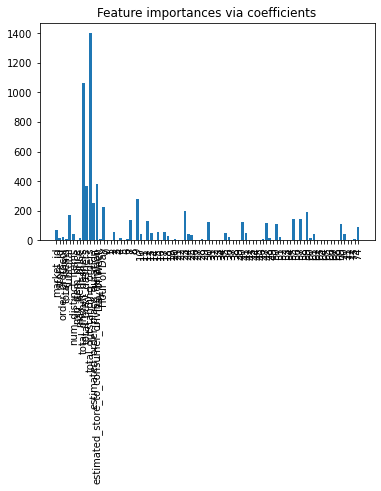

n lasso features greater than zero: 52


In [28]:
# lasso reduction
from sklearn.linear_model import LassoCV

lasso = LassoCV().fit(X_train_scaled, y_train)
importance = np.abs(lasso.coef_)
feature_names = np.array(X_train_scaled.columns)
plt.bar(height=importance, x=feature_names)
plt.xticks(rotation=90)
plt.title("Feature importances via coefficients")
plt.show()
print('n lasso features greater than zero:',(importance>0).sum())

In [29]:
# cull nonzero lasso features
from sklearn.feature_selection import SelectFromModel

threshold = np.sort(importance)[-52] 

tic = time()
sfm = SelectFromModel(lasso, threshold=threshold).fit(X_train_scaled, y_train)
toc = time()
print("Features selected by SelectFromModel: "
      f"{feature_names[sfm.get_support()]}")
print(f"Done in {toc - tic:.3f}s")

C:\Users\bscot\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Features selected by SelectFromModel: ['market_id' 'store_id' 'order_protocol' 'total_items' 'subtotal'
 'num_distinct_items' 'min_item_price' 'max_item_price'
 'total_onshift_dashers' 'total_busy_dashers' 'total_outstanding_orders'
 'estimated_order_place_duration'
 'estimated_store_to_consumer_driving_duration' 'Day of Week'
 'Hour of Day' '2' '4' '6' '7' '9' '10' '12' '13' '15' '17' '18' '20' '23'
 '24' '25' '28' '30' '34' '35' '36' '40' '41' '46' '47' '48' '50' '51'
 '52' '55' '57' '59' '60' '61' '69' '70' '73' '74']
Done in 3.412s


In [30]:
#
lasso_list = list(feature_names[sfm.get_support()])
X_train_scaled_lasso = X_train_scaled[lasso_list]
print(X_train_scaled_lasso.shape)
X_test_scaled_lasso = X_test_scaled[lasso_list]
print(X_test_scaled_lasso.shape)

(157942, 52)
(39486, 52)


In [32]:
# define lasso model
perceptron_model_lasso = keras.models.Sequential([Dense(20,activation = "sigmoid",input_shape = (52,)),
                                             Dense(20,activation = "sigmoid"),Dense(20,activation = "sigmoid"),
                                                Dense(1)])

perceptron_model_lasso.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 20)                1060      
_________________________________________________________________
dense_37 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_38 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 21        
Total params: 1,921
Trainable params: 1,921
Non-trainable params: 0
_________________________________________________________________


done in 282.391s


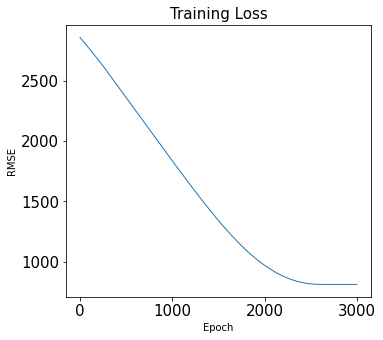

In [33]:
# compile model
perceptron_model_lasso.compile(optimizer='adam', loss='mae')


t0 = time()
# train model 
num_epochs = 3000
training_size = 100
batch_size = 2
steps_per_epoch = np.ceil(training_size/batch_size)
# data set length must be >= (training/batch)*epochs
#
history =perceptron_model_lasso.fit(X_train_scaled_lasso,y_train,
                             epochs=num_epochs,
                             steps_per_epoch=steps_per_epoch,
                             #callbacks=[checkpoint,kickout],
                             verbose=0)

t0_nn_lasso = (time() - t0)
print("done in %0.3fs" % (t0_nn_lasso))

# visualize learning curve
hist = history.history
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
ax.plot(hist['loss'],lw=1)
ax.set_title('Training Loss',size=15)
ax.set_xlabel('Epoch',size=10)
ax.set_ylabel('RMSE',size=10)
ax.tick_params(axis='both',which='major',labelsize=15)
#
plt.show()

In [34]:
# eval trained model on test set
mae_nn_test_lasso = perceptron_model_lasso.evaluate(X_test_scaled_lasso,y_test,verbose=0)
print('Neural network RMSE on test set:', mae_nn_test_lasso)

Neural network RMSE on test set: 801.0656127929688


In [35]:
# now with manual PCA reduction 
from sklearn.decomposition import PCA
# initialize PCA transformer
pca = PCA(n_components = None)
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
pca.explained_variance_ratio_

array([2.79215499e-01, 1.87350543e-01, 1.33402781e-01, 5.78647095e-02,
       4.72587308e-02, 3.95848303e-02, 3.61998427e-02, 3.24037597e-02,
       2.64043312e-02, 2.11808165e-02, 2.00500379e-02, 1.12034488e-02,
       9.33038900e-03, 8.50300893e-03, 7.54171418e-03, 7.14993348e-03,
       5.33214890e-03, 4.82598857e-03, 4.66093363e-03, 4.44024251e-03,
       4.40344180e-03, 4.00162379e-03, 3.67011148e-03, 3.58255881e-03,
       3.25212975e-03, 3.14318020e-03, 3.10791030e-03, 2.80955555e-03,
       2.69433272e-03, 2.46727268e-03, 2.09576011e-03, 1.93378356e-03,
       1.71857607e-03, 1.48960839e-03, 1.37164797e-03, 1.26883297e-03,
       1.16926997e-03, 1.10577699e-03, 9.86136176e-04, 9.37494257e-04,
       8.66227526e-04, 8.27167033e-04, 7.76892956e-04, 7.39934099e-04,
       5.88073396e-04, 5.56310838e-04, 4.36895295e-04, 4.12095346e-04,
       3.33220694e-04, 3.10322615e-04, 2.97677471e-04, 2.69343276e-04,
       2.59141468e-04, 1.84041324e-04, 1.65534036e-04, 1.53747001e-04,
      

In [36]:
# print explained variance
tot = sum(pca.explained_variance_ratio_)
var_exp = [(i/tot) for i in
          sorted(pca.explained_variance_ratio_,reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)

[0.2792155  0.46656604 0.59996882 0.65783353 0.70509226 0.74467709
 0.78087694 0.8132807  0.83968503 0.86086584 0.88091588 0.89211933
 0.90144972 0.90995273 0.91749444 0.92464438 0.92997653 0.93480251
 0.93946345 0.94390369 0.94830713 0.95230876 0.95597887 0.95956143
 0.96281356 0.96595674 0.96906465 0.9718742  0.97456853 0.97703581
 0.97913157 0.98106535 0.98278393 0.98427354 0.98564518 0.98691402
 0.98808329 0.98918906 0.9901752  0.99111269 0.99197892 0.99280609
 0.99358298 0.99432292 0.99491099 0.9954673  0.99590419 0.99631629
 0.99664951 0.99695983 0.99725751 0.99752685 0.997786   0.99797004
 0.99813557 0.99828932 0.99843698 0.99857903 0.99871769 0.99885208
 0.99898166 0.9990984  0.99919642 0.9992828  0.99936008 0.99943446
 0.99950598 0.99957149 0.99963302 0.99968695 0.99972684 0.99976484
 0.99980219 0.99983556 0.99986509 0.9998914  0.99990947 0.9999256
 0.99994052 0.9999551  0.99996791 0.99997829 0.99998844 0.99999358
 0.99999807 0.99999873 0.99999937 1.         1.         1.     

In [37]:
# export PCs and explore in excel
# n PCs based on cumulative df above
pca = PCA(n_components = 8)
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
loadings = pd.DataFrame(pca.components_.T, index=(X_train_scaled.columns))
loadings.to_csv (r'C:/Users/bscot/OneDrive/Documents/DoorDash//DoorDash2/nn_pca_components.csv', index = True, header=True)
loadings

,0,1,2,3,4,5,6,7
market_id,-0.000758,-0.038806,0.041105,0.995638,0.024457,-0.004799,-0.006909,-0.025820
store_id,-0.004498,0.011846,0.004408,0.028054,-0.010043,0.018767,-0.067527,0.994482
order_protocol,0.003085,-0.041723,0.093041,-0.035370,0.025654,0.461157,-0.563539,-0.026806
total_items,0.769841,0.173414,0.073324,0.005942,0.075204,0.428716,0.371656,0.018061
subtotal,0.398982,-0.139170,-0.411041,0.000104,-0.035436,-0.220751,-0.288128,0.002388
...,...,...,...,...,...,...,...,...
70,0.005813,-0.005336,0.004307,0.009971,-0.000098,-0.013463,-0.009712,-0.007834
71,0.000048,-0.000378,0.000063,0.000926,0.000250,0.000064,-0.000381,-0.000218
72,-0.000218,0.000564,-0.000391,-0.000710,-0.000432,-0.000779,0.001116,-0.000599
73,-0.000011,-0.000543,0.000765,-0.000411,-0.000531,-0.000394,-0.000345,-0.001886


In [38]:
# Create PCA data sets

X_train_scaled_pca = X_train_scaled[['total_items',
                                    'min_item_price',
                                    'subtotal',
                                    'order_protocol',
                                    'estimated_store_to_consumer_driving_duration',
                                    'num_distinct_items',
                                    'max_item_price',
                                    'estimated_order_place_duration',
                                    'store_id',
                                    'market_id',
                                    'total_outstanding_orders',
                                    'total_onshift_dashers',
                                    'total_busy_dashers',]]


X_test_scaled_pca = X_test_scaled[['total_items',
                                    'min_item_price',
                                    'subtotal',
                                    'order_protocol',
                                    'estimated_store_to_consumer_driving_duration',
                                    'num_distinct_items',
                                    'max_item_price',
                                    'estimated_order_place_duration',
                                    'store_id',
                                    'market_id',
                                    'total_outstanding_orders',
                                    'total_onshift_dashers',
                                    'total_busy_dashers',]]


print(X_train_scaled_pca.shape)
print(X_test_scaled_pca.shape)

(157942, 13)
(39486, 13)


In [39]:
# define pca model
perceptron_model_pca = keras.models.Sequential([Dense(20,activation = "sigmoid",input_shape = (13,)),
                                             Dense(20,activation = "sigmoid"),Dense(20,activation = "sigmoid"),
                                                Dense(1)])

perceptron_model_pca.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 20)                280       
_________________________________________________________________
dense_41 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_42 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 21        
Total params: 1,141
Trainable params: 1,141
Non-trainable params: 0
_________________________________________________________________


done in 200.103s


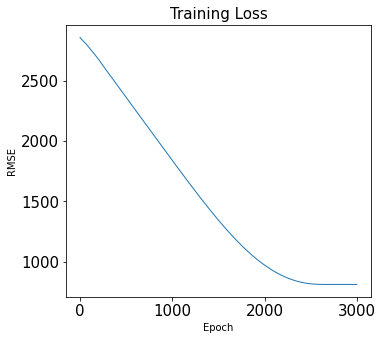

In [40]:
# compile model
perceptron_model_pca.compile(optimizer='adam', loss='mae')

t0 = time()
# train model 
num_epochs = 3000
training_size = 100
batch_size = 2
steps_per_epoch = np.ceil(training_size/batch_size)
# data set length must be >= (training/batch)*epochs
#
history =perceptron_model_pca.fit(X_train_scaled_pca,y_train,
                             epochs=num_epochs,
                             steps_per_epoch=steps_per_epoch,
                             #callbacks=[checkpoint,kickout],
                             verbose=0)

t0_nn_pca = (time() - t0)
print("done in %0.3fs" % (t0_nn_pca))

# visualize learning curve
hist = history.history
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
ax.plot(hist['loss'],lw=1)
ax.set_title('Training Loss',size=15)
ax.set_xlabel('Epoch',size=10)
ax.set_ylabel('RMSE',size=10)
ax.tick_params(axis='both',which='major',labelsize=15)
#
plt.show()

In [41]:
# eval trained model on test set
mae_nn_test_pca = perceptron_model_pca.evaluate(X_test_scaled_pca,y_test,verbose=0)
print('Neural network RMSE on test set:', mae_nn_test_pca)

Neural network RMSE on test set: 801.065673828125


In [42]:
from tabulate import tabulate

table = [["RMSE",mae_nn_test,mae_nn_test_lasso,mae_nn_test_pca],
["Time",(t0_nn),(t0_nn_lasso),(t0_nn_pca)]]
headers = ["Metric", "Full","Lasso_culled","PCA_culled"]
print(tabulate(table, headers, tablefmt="plain",numalign="right"))

Metric       Full    Lasso_culled    PCA_culled
RMSE      801.065         801.066       801.066
Time       485.84         282.391       200.103


In [46]:
# select model w min features, proceed w cross validation 

def create_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(50, input_shape=(13,) , activation = 'sigmoid'))
    model.add(tf.keras.layers.Dense(50, activation = 'sigmoid'))
    model.add(tf.keras.layers.Dense(50, activation = 'sigmoid'))
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(optimizer='adam', loss='mae')
    
    return model

In [47]:
# use full data set for kfold 
X_kfold = X[['total_items',
                                    'min_item_price',
                                    'subtotal',
                                    'order_protocol',
                                    'estimated_store_to_consumer_driving_duration',
                                    'num_distinct_items',
                                    'max_item_price',
                                    'estimated_order_place_duration',
                                    'store_id',
                                    'market_id',
                                    'total_outstanding_orders',
                                    'total_onshift_dashers',
                                    'total_busy_dashers',]]

print(X_kfold.shape)

(197428, 13)


In [48]:
from sklearn.model_selection import KFold
# train model 
num_epochs = 3000
training_size = 100
batch_size = 2
steps_per_epoch = np.ceil(training_size/batch_size)
# data set length must be >= (training/batch)*epochs

n_split=5

for train_index,test_index in KFold(n_split).split(X_kfold):
    # need to convert pandas to numpy w iloc
    X_train_kfold,X_test_kfold=X_kfold.iloc[train_index],X_kfold.iloc[test_index]
    y_train,y_test=y.iloc[train_index],y.iloc[test_index]
    
    model=create_model()
    model.fit(X_train_kfold, y_train,
            epochs=num_epochs,
            steps_per_epoch=steps_per_epoch,
            #callbacks=[checkpoint,kickout],
            verbose=0)
    
    print('Model evaluation ',model.evaluate(X_test_kfold,y_test))

1234/1234 [==============================] - 1s 448us/step - loss: 821.4955
Model evaluation  821.4954833984375
1234/1234 [==============================] - 1s 394us/step - loss: 807.1804
Model evaluation  807.1803588867188
1234/1234 [==============================] - 0s 336us/step - loss: 798.2433
Model evaluation  798.2432861328125
1234/1234 [==============================] - 1s 368us/step - loss: 804.1272
Model evaluation  804.127197265625
1234/1234 [==============================] - 0s 348us/step - loss: 809.8375
Model evaluation  809.8375244140625
